In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================================
# Load Saved DataFrame from Pickle File
# ============================================================================

import pandas as pd

# Path to previously saved pickle file
PICKLE_PATH =  "/content/drive/MyDrive/MSc Research/final_df.pkl"

# Load the DataFrame
df = pd.read_pickle(PICKLE_PATH)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188988 entries, 0 to 256135
Data columns (total 47 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   NCD_GRANTED_YEARS_B                188988 non-null  float64
 1   NCD_GRANTED_YEARS_C                188988 non-null  float64
 2   BEDROOMS                           188988 non-null  float64
 3   LEGAL_ADDON_PRE_REN                188988 non-null  int64  
 4   LEGAL_ADDON_POST_REN               188988 non-null  int64  
 5   HOME_EM_ADDON_PRE_REN              188988 non-null  int64  
 6   HOME_EM_ADDON_POST_REN             188988 non-null  int64  
 7   GARDEN_ADDON_PRE_REN               188988 non-null  int64  
 8   KEYCARE_ADDON_PRE_REN              188988 non-null  int64  
 9   KEYCARE_ADDON_POST_REN             188988 non-null  int64  
 10  HP1_ADDON_PRE_REN                  188988 non-null  int64  
 11  HP1_ADDON_POST_REN                 188988 no

In [ ]:
import os, csv, json, joblib, time
import numpy as np
import pandas as pd


from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    ParameterGrid,
    KFold
)

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# =============================================================================
# Subsampling & Model Evaluation
# =============================================================================
def stratified_subsample(data, frac=0.1, n_bins=10, random_state=42):
    if frac >= 1.0:
        return data.copy()
    tmp = data.copy()
    tmp["prem_bin"] = pd.qcut(tmp["PREMIUM"], q=n_bins, labels=False, duplicates="drop")
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=frac, random_state=random_state)
    idx = next(splitter.split(tmp, tmp["prem_bin"]))[1]
    return tmp.iloc[idx].drop(columns=["prem_bin"])

# **Random Forest Hyperparameter Tuning**

## **Random Forest (10% data)**

In [ ]:
# =============================================================================
# Random Forest Hyperparameter Tuning with GridSearchCV (10% data, RMSE scoring)
# =============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import numpy as np

# 1) Define the hyperparameter GRID for Random Forest on 10% data
param_grid_rf_10 = {
    'n_estimators': [1500],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [8, 15, 30],
    'max_features': [7, 15, 23, 37, 46],
    'criterion': ['squared_error'],
}

# 2) Prepare the data for 10% subsample (~18,899 samples)
df_10 = stratified_subsample(df, frac=0.10, n_bins=10, random_state=42)
X_10 = df_10.drop(columns=["PREMIUM"])
y_10 = df_10["PREMIUM"]

# 3) Split 10% subsample into train and test
X_tr_10, X_te_10, y_tr_10, y_te_10 = train_test_split(
    X_10, y_10, test_size=0.2, random_state=42
)

# 4) Initialize the base Random Forest model
rf_10 = RandomForestRegressor(random_state=42)

# 5) Configure GridSearchCV for the 10% data with RMSE scoring
grid_search_rf_10 = GridSearchCV(
    estimator=rf_10,
    param_grid=param_grid_rf_10,
    scoring='neg_root_mean_squared_error',  # RMSE (negative because sklearn maximizes)
    cv=5,
    n_jobs=1,
    verbose=2
)

# 6) Run the search
print("Tuning Random Forest on 10% of data …")
grid_search_rf_10.fit(X_tr_10, y_tr_10)

# 7) Report best hyperparameters and CV RMSE
best_params_rf_10 = grid_search_rf_10.best_params_
best_cv_rmse_rf_10 = -grid_search_rf_10.best_score_  # convert back to positive RMSE
print(f"\nBest hyperparameters for 10% data: {best_params_rf_10}")
print(f"↳ CV RMSE (avg) for Random Forest (10%): {best_cv_rmse_rf_10:.4f}")

# 8) Evaluate the best estimator on the held‐out 20% test split
best_rf_model_10 = grid_search_rf_10.best_estimator_
y_pred_rf_10 = best_rf_model_10.predict(X_te_10)

test_r2_rf_10   = r2_score(y_te_10, y_pred_rf_10)
test_mae_rf_10  = mean_absolute_error(y_te_10, y_pred_rf_10)
test_rmse_rf_10 = np.sqrt(mean_squared_error(y_te_10, y_pred_rf_10))
test_mape_rf_10 = mean_absolute_percentage_error(y_te_10, y_pred_rf_10)

print("\nTest set performance for Random Forest (10% data):")
print(f" • R²   = {test_r2_rf_10:.4f}")
print(f" • MAE  = {test_mae_rf_10:.2f}")
print(f" • RMSE = {test_rmse_rf_10:.2f}")
print(f" • MAPE = {test_mape_rf_10:.2%}")


Tuning Random Forest on 10% of data …
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=8, min_samples_split=2, n_estimators=800; total time=  15.5s
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=8, min_samples_split=2, n_estimators=800; total time=  15.6s
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=8, min_samples_split=2, n_estimators=800; total time=  16.0s
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=8, min_samples_split=2, n_estimators=800; total time=  15.0s
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=8, min_samples_split=2, n_estimators=800; total time=  15.7s
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=15, min_samples_split=2, n_estimators=800; total time=  12.9s
[CV] END criterion=squared_error, ma

In [ ]:
import joblib

# Save the trained model to disk
joblib.dump(best_rf_model_10, r"C:\Users\ellio\Desktop\MSc Dissertation\rf_model_10percent.pkl")

['C:\\Users\\ellio\\Desktop\\MSc Dissertation\\rf_model_10percent.pkl']

#### Explainability

In [ ]:
import shap, joblib, pandas as pd, numpy as np, os, json

# ── Load best RF model (10%) ─────────────────────────────────────────
rf_10 = joblib.load("/content/drive/MyDrive/MSc Research/Random Forest/rf_model_10percent.pkl")

# ── Use the same 10% subsample for SHAP explanations ────────────────
full_df_10 = stratified_subsample(df, frac=0.10, n_bins=10, random_state=42)
X_full_10  = full_df_10.drop(columns=["PREMIUM"])

# ── SHAP unified Explainer (approximate) ────────────────────────────
explainer   = shap.Explainer(rf_10, X_full_10)   # faster, path-dependent approximation
shap_values = explainer(X_full_10)               # returns shap.Explanation object


  1%|                   | 250/18899 [07:37<568:10]       

In [ ]:
# ── Save artefacts ──────────────────────────────────────────────────
out_dir = "/content/drive/MyDrive/MSc Research/EXPLAIN_RF"
os.makedirs(out_dir, exist_ok=True)

lab, frac = "10", 0.10

# 1) Raw SHAP values
np.savez_compressed(f"{out_dir}/rf_shap_values_{lab}.npz",
    shap_values=shap_values.astype(np.float32),
    feature_names=np.array(X_full_10.columns),
    expected_value=np.atleast_1d(shap_exp.base_values).astype(np.float32)
)

# 2) Per-feature summary
df_feat = pd.DataFrame({
    "feature": X_full_10.columns,
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0)
}).sort_values("mean_abs_shap", ascending=False)
df_feat["sample_label"], df_feat["sample_frac"] = lab, frac
df_feat.to_csv(f"{out_dir}/rf_mean_shap_{lab}.csv", index=False)

# 3) Meta
json.dump({"sample_label": lab, "frac": frac, "n_rows": len(X_full_10)},
          open(f"{out_dir}/rf_shap_meta_{lab}.json", "w"))

print("Saved RF SHAP data for 10% sample")

## **Random Forest (25% data)**

In [ ]:
# =============================================================================
# Random Forest Hyperparameter Tuning with GridSearchCV (25% data, RMSE scoring)
# =============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import numpy as np
import matplotlib.pyplot as plt

# 1) Define the hyperparameter GRID for Random Forest on 25% data
param_grid_rf_25 = {
    'n_estimators': [1000],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [15, 19, 30],
    'min_weight_fraction_leaf': [0.0],
    'max_features': [7, 15, 23, 37, 46],
    'criterion': ['squared_error'],
}

# 2) Prepare the data for 25% subsample (47,247 samples)
full_df_25 = stratified_subsample(df, frac=0.25)  # 25% of data
X_full_25 = full_df_25.drop(columns=["PREMIUM"])
y_full_25 = full_df_25["PREMIUM"]

# Split data into train and test
X_tr_25, X_te_25, y_tr_25, y_te_25 = train_test_split(
    X_full_25, y_full_25, test_size=0.2, random_state=42
)

# 3) Initialize the Random Forest model
rf_25 = RandomForestRegressor(random_state=42)

# 4) Configure GridSearchCV for 25% data with RMSE scoring
grid_search_rf_25 = GridSearchCV(
    estimator=rf_25,
    param_grid=param_grid_rf_25,
    scoring='neg_root_mean_squared_error',  # RMSE (sklearn maximizes, so it's negative)
    cv=5,
    n_jobs=1,
    verbose=2
)

# 5) Run the search on the 25% subsample
print("Tuning Random Forest on 25% of data …")
grid_search_rf_25.fit(X_tr_25, y_tr_25)

# 6) Best CV results for 25% data
best_params_rf_25 = grid_search_rf_25.best_params_
best_cv_rmse_rf_25 = -grid_search_rf_25.best_score_  # convert back to positive RMSE
print(f"\nBest hyperparameters for 25% data: {best_params_rf_25}")
print(f"↳ CV RMSE (avg) for Random Forest (25%): {best_cv_rmse_rf_25:.4f}")

# 7) Evaluate on held-out test set
best_rf_model_25 = grid_search_rf_25.best_estimator_
y_pred_rf_25 = best_rf_model_25.predict(X_te_25)

test_r2_rf_25 = r2_score(y_te_25, y_pred_rf_25)
test_mae_rf_25 = mean_absolute_error(y_te_25, y_pred_rf_25)
test_rmse_rf_25 = np.sqrt(mean_squared_error(y_te_25, y_pred_rf_25))
test_mape_rf_25 = mean_absolute_percentage_error(y_te_25, y_pred_rf_25)

print("\n Test set performance for Random Forest (25% data):")
print(f" • R²   = {test_r2_rf_25:.4f}")
print(f" • MAE  = {test_mae_rf_25:.2f}")
print(f" • RMSE = {test_rmse_rf_25:.2f}")
print(f" • MAPE = {test_mape_rf_25:.2%}")


Tuning Random Forest on 25% of data …
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=15, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1000; total time=  48.0s
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=15, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1000; total time=  46.5s
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=15, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1000; total time=  43.0s
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=15, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1000; total time=  41.8s
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=15, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1000; total time=  42.0s
[CV] END criterion=sq

In [ ]:
import joblib

# Save the best trained model
joblib.dump(best_rf_model_25, r"C:\Users\ellio\Desktop\MSc Dissertation\rf_model_25_%.joblib")


['C:\\Users\\ellio\\Desktop\\MSc Dissertation\\rf_model_25_%.joblib']

##### **EXPLAINABILITY on 25%**

In [ ]:
import json
from sklearn.ensemble import RandomForestRegressor

with open(r"C:\Users\ellio\Desktop\MSc Dissertation\rfr_best_params_25.json", "r") as f:
    best_params_rf_25 = json.load(f)

# Re-initialize model
rf_best_model_25 = RandomForestRegressor(
    n_estimators=100,
    max_depth=best_params_rf_25['max_depth'],
    min_samples_split=best_params_rf_25['min_samples_split'],
    min_samples_leaf=best_params_rf_25['min_samples_leaf'],
    max_features=best_params_rf_25['max_features'],
    criterion=best_params_rf_25['criterion'],
    random_state=42
)


In [ ]:
# Get 25% stratified data
full_df_25 = stratified_subsample(df, frac=0.25)
X_full_25 = full_df_25.drop(columns=["PREMIUM"])
y_full_25 = full_df_25["PREMIUM"]

# Fit model
rf_best_model_25.fit(X_full_25, y_full_25)


RandomForestRegressor(max_features=10, min_samples_leaf=5, random_state=42)

In [ ]:
import shap

explainer_25 = shap.Explainer(rf_best_model_25, X_full_25)
shap_values_exp_25 = explainer_25(X_full_25)


100%|===================| 47245/47247 [188:52<00:00]        

## **Random Forest (50% data)**

In [ ]:
# =============================================================================
# Random Forest Hyperparameter Tuning with GridSearchCV (50% data, RMSE scoring)
# =============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import numpy as np
import matplotlib.pyplot as plt

# 1) Define the hyperparameter grid for Random Forest on 50% data
param_grid_rf_50 = {
    'n_estimators': [1200],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [19, 30, 38],
    'min_weight_fraction_leaf': [0.0],
    'max_features': [7, 15, 23, 37, 46],
    'criterion': ['squared_error'],
}

# 2) Prepare the data for 50% subsample (94,494 samples)
full_df_50 = stratified_subsample(df, frac=0.5)  # 50% of data
X_full_50 = full_df_50.drop(columns=["PREMIUM"])
y_full_50 = full_df_50["PREMIUM"]

# Split data into train and test
X_tr_50, X_te_50, y_tr_50, y_te_50 = train_test_split(
    X_full_50, y_full_50, test_size=0.2, random_state=42
)

# 3) Initialize the Random Forest model
rf_50 = RandomForestRegressor(random_state=42)

# 4) Configure GridSearchCV for 50% data with RMSE scoring
grid_search_rf_50 = GridSearchCV(
    estimator=rf_50,
    param_grid=param_grid_rf_50,
    scoring='neg_root_mean_squared_error',  # RMSE (sklearn maximizes score)
    cv=5,
    n_jobs=1,
    verbose=2
)

# 5) Run the search on the 50% subsample
print("Tuning Random Forest on 50% of data")
grid_search_rf_50.fit(X_tr_50, y_tr_50)

# 6) Best CV results for 50% data
best_params_rf_50 = grid_search_rf_50.best_params_
best_cv_rmse_rf_50 = -grid_search_rf_50.best_score_  # convert back to positive RMSE
print(f"\nBest hyperparameters for 50% data: {best_params_rf_50}")
print(f"↳ CV RMSE (avg) for Random Forest (50%): {best_cv_rmse_rf_50:.4f}")

# 7) Evaluate on held-out test set
best_rf_model_50 = grid_search_rf_50.best_estimator_
y_pred_rf_50 = best_rf_model_50.predict(X_te_50)

test_r2_rf_50 = r2_score(y_te_50, y_pred_rf_50)
test_mae_rf_50 = mean_absolute_error(y_te_50, y_pred_rf_50)
test_rmse_rf_50 = np.sqrt(mean_squared_error(y_te_50, y_pred_rf_50))
test_mape_rf_50 = mean_absolute_percentage_error(y_te_50, y_pred_rf_50)

print("\n Test set performance for Random Forest (50% data):")
print(f" • R²   = {test_r2_rf_50:.4f}")
print(f" • MAE  = {test_mae_rf_50:.2f}")
print(f" • RMSE = {test_rmse_rf_50:.2f}")
print(f" • MAPE = {test_mape_rf_50:.2%}")

# 8) Save tuning summary & best params for Random Forest on 50% Dataset
tuning_summary_rf_50 = {
    "Fraction": 0.5,
    "CV_RMSE": best_cv_rmse_rf_50,
    "Test_R2":  test_r2_rf_50,
    "Test_MAE": test_mae_rf_50,
    "Test_RMSE": test_rmse_rf_50,
    "Test_MAPE": test_mape_rf_50,
    **best_params_rf_50
}


Tuning Random Forest on 50% of data
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1200; total time= 2.7min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1200; total time= 2.5min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1200; total time= 2.5min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1200; total time= 2.5min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1200; total time=11.0min
[CV] END criterion=squa

In [ ]:
import joblib

# Save the best trained model
joblib.dump(best_rf_model_50, r"C:\Users\ellio\Desktop\MSc Dissertation\random_forest_50%.joblib")


## **Random Forest (75% data)**

In [ ]:
# =============================================================================
# Random Forest Hyperparameter Tuning with GridSearchCV (0.75% data, RMSE scoring)
# =============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import numpy as np

# 1) Hyperparameter GRID for a very small (0.75%) subsample
param_grid_rf_075 = {
    'n_estimators': [1600],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [19, 38, 50],
    'max_features': [7, 15, 23, 37, 46],
    'criterion': ['squared_error'],
}

# 2) Prepare the data for 0.75% subsample
df_075 = stratified_subsample(df, frac=0.75)
X_075 = df_075.drop(columns=["PREMIUM"])
y_075 = df_075["PREMIUM"]

# 3) Train/test split
X_tr_075, X_te_075, y_tr_075, y_te_075 = train_test_split(
    X_075, y_075, test_size=0.2, random_state=42
)

# 4) Base model
rf_075 = RandomForestRegressor(random_state=42)

# 5) GridSearchCV with RMSE scoring
grid_search_rf_075 = GridSearchCV(
    estimator=rf_075,
    param_grid=param_grid_rf_075,
    scoring='neg_root_mean_squared_error',  # RMSE (negated for maximization)
    cv=5,
    n_jobs=1,
    verbose=2
)

# 6) Run the search
print("Tuning Random Forest on 0.75% of data …")
grid_search_rf_075.fit(X_tr_075, y_tr_075)

# 7) Best hyperparameters and CV RMSE
best_params_rf_075 = grid_search_rf_075.best_params_
best_cv_rmse_rf_075 = -grid_search_rf_075.best_score_
print(f"\nBest hyperparameters for 0.75% data: {best_params_rf_075}")
print(f"↳ CV RMSE (avg) for Random Forest (0.75%): {best_cv_rmse_rf_075:.4f}")

# 8) Evaluate on held-out test split
best_rf_model_075 = grid_search_rf_075.best_estimator_
y_pred_rf_075 = best_rf_model_075.predict(X_te_075)

test_r2_rf_075   = r2_score(y_te_075, y_pred_rf_075)
test_mae_rf_075  = mean_absolute_error(y_te_075, y_pred_rf_075)
test_rmse_rf_075 = np.sqrt(mean_squared_error(y_te_075, y_pred_rf_075))
test_mape_rf_075 = mean_absolute_percentage_error(y_te_075, y_pred_rf_075)

print("\nTest set performance for Random Forest (0.75% data):")
print(f" • R²   = {test_r2_rf_075:.4f}")
print(f" • MAE  = {test_mae_rf_075:.2f}")
print(f" • RMSE = {test_rmse_rf_075:.2f}")
print(f" • MAPE = {test_mape_rf_075:.2%}")


Tuning Random Forest on 0.75% of data …
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, n_estimators=1600; total time= 5.8min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, n_estimators=1600; total time= 5.7min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, n_estimators=1600; total time= 5.7min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, n_estimators=1600; total time= 5.7min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, n_estimators=1600; total time= 5.7min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=38, min_samples_split=2, n_estimators=1600; total time= 5.1min
[CV] END criterion=squa

In [ ]:
import joblib

# Save the best trained model
joblib.dump(best_rf_model_075, r"C:\Users\ellio\Desktop\MSc Dissertation\rf_75pct_model.joblib")


['C:\\Users\\ellio\\Desktop\\MSc Dissertation\\rf_75pct_model.joblib']

## **Random Forest (100% data)**

In [ ]:
# =============================================================================
# Random Forest Hyperparameter Tuning with GridSearchCV (100% data, RMSE scoring)
# =============================================================================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import numpy as np
import matplotlib.pyplot as plt

# 1) Define the hyperparameter grid for Random Forest on 100% data
param_grid_rf_full = {
    'n_estimators': [1600],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [19, 38, 50],
    'min_weight_fraction_leaf': [0.0],
    'max_features': [7, 15, 23, 37, 46],
    'criterion': ['squared_error'],
}

X_full = df.drop(columns=["PREMIUM"])  # Features
y_full = df["PREMIUM"]                  # Target

# 2) Split data into train and test
X_tr_full, X_te_full, y_tr_full, y_te_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

# 3) Initialize the Random Forest model
rf_full = RandomForestRegressor(random_state=42)

# 4) Configure GridSearchCV for 100% data with RMSE scoring
grid_search_rf_full = GridSearchCV(
    estimator=rf_full,
    param_grid=param_grid_rf_full,
    scoring='neg_root_mean_squared_error',  # RMSE (negative because sklearn maximizes score)
    cv=5,
    n_jobs=1,
    verbose=2
)

# 5) Run the search on the full dataset
grid_search_rf_full.fit(X_tr_full, y_tr_full)

# 6) Best CV results for 100% data
best_params_rf_full = grid_search_rf_full.best_params_
best_cv_rmse_rf_full = -grid_search_rf_full.best_score_  # convert back to positive RMSE
print(f"\nBest hyperparameters for 100% data: {best_params_rf_full}")
print(f" CV RMSE (avg) for Random Forest (100%): {best_cv_rmse_rf_full:.4f}")

# 7) Evaluate on held-out test set
best_rf_model_full = grid_search_rf_full.best_estimator_
y_pred_rf_full = best_rf_model_full.predict(X_te_full)

test_r2_rf_full = r2_score(y_te_full, y_pred_rf_full)
test_mae_rf_full = mean_absolute_error(y_te_full, y_pred_rf_full)
test_rmse_rf_full = np.sqrt(mean_squared_error(y_te_full, y_pred_rf_full))
test_mape_rf_full = mean_absolute_percentage_error(y_te_full, y_pred_rf_full)

print("\n Test set performance for Random Forest (100% data):")
print(f" • R²   = {test_r2_rf_full:.4f}")
print(f" • MAE  = {test_mae_rf_full:.2f}")
print(f" • RMSE = {test_rmse_rf_full:.2f}")
print(f" • MAPE = {test_mape_rf_full:.2%}")

# 8) Save tuning summary & best params for Random Forest on Full Dataset
tuning_summary_rf_full = {
    "Fraction": 1.0,
    "CV_RMSE": best_cv_rmse_rf_full,
    "Test_R2":  test_r2_rf_full,
    "Test_MAE": test_mae_rf_full,
    "Test_RMSE": test_rmse_rf_full,
    "Test_MAPE": test_mape_rf_full,
    **best_params_rf_full
}


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1600; total time= 7.6min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1600; total time= 7.5min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1600; total time= 7.6min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1600; total time= 7.6min
[CV] END criterion=squared_error, max_depth=None, max_features=7, min_samples_leaf=19, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=1600; total time= 7.5min
[CV] END criterion=squared_error, max_depth=None, max_featu

In [ ]:
import joblib

# Save the best trained model
joblib.dump(best_rf_model_full, r"C:\Users\ellio\Desktop\MSc Dissertation\rf_100pct_model.joblib")


['C:\\Users\\ellio\\Desktop\\MSc Dissertation\\rf_100pct_model.joblib']

# **HPT part 2**

In [ ]:
# =========================
# PART 1 — Setup & Globals
# =========================
import os, json, joblib
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    r2_score, mean_absolute_error,
    mean_squared_error, mean_absolute_percentage_error
)

# ---- Paths ----
BASE_DIR  = "/content/drive/MyDrive/MSc Research/Random Forest/RF"
ARTIFACTS_DIR = os.path.join(BASE_DIR, "artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# ---- Random Forest tuning policy (supervisor guidance) ----
RANDOM_STATE            = 42
SCORING_METHOD          = "neg_root_mean_squared_error"   # RMSE (negative in sklearn)

N_ESTIMATORS_FIXED      = 1500        # n_estimators (fixed, not tuned)
MIN_SAMPLES_SPLIT_FIXED = 2           # min_samples_split (fixed, not tuned)
MIN_SAMPLES_LEAF_SET    = [1, 25, 50] # consistent across all datasets

DATA_FRACTIONS          = [0.10, 0.25, 0.50, 0.75, 1.00]  # dataset subset sizes

COARSE_MAX_FEATURES     = [7, 15, 23, 37, 46]             # coarse search values
REFINED_MAX_FEATURES    = list(range(22, 28))             # refined search (20..26)


# =====================================
# PART 2 — Helpers
# =====================================
def _clip_max_features(m_list, p_features):
    """Ensure candidate max_features values are within [1, p_features]."""
    return sorted(set(max(1, min(p_features, int(m))) for m in m_list))

def build_grid_max_features(m_list, p_features, include_leaf=True):
    """Grid for tuning only max_features, keeping other params fixed."""
    grid = {
        "n_estimators": [N_ESTIMATORS_FIXED],
        "max_depth": [None],
        "min_samples_split": [MIN_SAMPLES_SPLIT_FIXED],
        "max_features": _clip_max_features(m_list, p_features),
        "criterion": ["squared_error"],
        "bootstrap": [True],
    }
    grid["min_samples_leaf"] = (MIN_SAMPLES_LEAF_SET[:] if include_leaf else [1])
    return grid

def run_grid_cv(Xtr, ytr, grid, cv=5):
    """Run GridSearchCV and return estimator + results DataFrame."""
    rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    gs = GridSearchCV(
        rf, grid, scoring=SCORING_METHOD, cv=cv, n_jobs=1, verbose=2, return_train_score=False
    )
    gs.fit(Xtr, ytr)
    cvres = pd.DataFrame(gs.cv_results_).copy()
    cvres["rmse"] = -cvres["mean_test_score"]   # convert neg RMSE to positive
    return gs, cvres

def evaluate(final_rf, Xte, yte):
    """Evaluate model on held-out test set."""
    ypred = final_rf.predict(Xte)
    return {
        "Test_R2":  float(r2_score(yte, ypred)),
        "Test_MAE": float(mean_absolute_error(yte, ypred)),
        "Test_RMSE": float(np.sqrt(mean_squared_error(yte, ypred))),
        "Test_MAPE": float(mean_absolute_percentage_error(yte, ypred)),
    }


# =====================================
# PART 3 — Run one fraction (refined only)
# =====================================
def run_rf_for_fraction(df, frac: float, cv_folds: int = 5):
    print(f"\n=== Random Forest tuning (refined only) for {int(frac*100)}% subset ===")

    # Subsample (assumes you already have stratified_subsample function)
    dsub = stratified_subsample(df, frac=frac, n_bins=10, random_state=RANDOM_STATE)
    X = dsub.drop(columns=["PREMIUM"])
    y = dsub["PREMIUM"].to_numpy()
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
    p = Xtr.shape[1]

    # ---- Refined search only ----
    grid_refined = build_grid_max_features(REFINED_MAX_FEATURES, p, include_leaf=True)
    gs_refined, cv_refined = run_grid_cv(Xtr, ytr, grid_refined, cv=cv_folds)
    cv_refined_path = os.path.join(ARTIFACTS_DIR, f"rf_cv_refined_{int(frac*100)}.csv")
    cv_refined.to_csv(cv_refined_path, index=False)

    # ---- Final params ----
    best_params = gs_refined.best_params_.copy()
    best_params.update({
        "n_estimators": N_ESTIMATORS_FIXED,
        "min_samples_split": MIN_SAMPLES_SPLIT_FIXED,
        "max_depth": None,
        "bootstrap": True,
        "criterion": "squared_error",
    })

    # ---- Train final model ----
    final_rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1, **best_params)
    final_rf.fit(Xtr, ytr)
    metrics = evaluate(final_rf, Xte, yte)

    # ---- Save model ----
    model_path = os.path.join(ARTIFACTS_DIR, f"rf_model_{int(frac*100)}.joblib")
    joblib.dump(final_rf, model_path)

    # ---- Return summary dict ----
    return {
        "subset": f"{int(frac*100)}%",
        "n_train": int(Xtr.shape[0]),
        "p_features": int(p),
        "final_params": dict(best_params),
        "cv_rmse_refined_best": float(-gs_refined.best_score_),
        **metrics,
        "model_path": model_path,
        "cv_refined_csv": cv_refined_path,
    }


In [ ]:
s10 = run_rf_for_fraction(df, 0.10)


=== Random Forest tuning (refined only) for 10% subset ===
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=22, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.2min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=22, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.4min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=22, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.3min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=22, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.2min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=22, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.2min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max

In [ ]:
s25 = run_rf_for_fraction(df, 0.25)


=== Random Forest tuning (refined only) for 25% subset ===
Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  24.8s
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  24.3s
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  24.6s
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  24.8s
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  25.8s
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, ma

In [ ]:
s50 = run_rf_for_fraction(df, 0.50)


=== Random Forest tuning (refined only) for 50% subset ===
Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.0min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  56.6s
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  55.2s
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  55.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time=  54.7s
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, ma

In [ ]:
s75 = run_rf_for_fraction(df, 0.75)


=== Random Forest tuning (refined only) for 75% subset ===
Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.4min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.4min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.4min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.3min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 1.3min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, ma

In [ ]:
s100 = run_rf_for_fraction(df, 1.00)


=== Random Forest tuning (refined only) for 100% subset ===
Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 2.0min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 2.0min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 2.0min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 2.0min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, max_features=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1500; total time= 2.0min
[CV] END bootstrap=True, criterion=squared_error, max_depth=None, m

In [ ]:
# Initialise empty list once
all_summaries = []
all_summaries.append(s10)

# When ready, save
summary_df   = pd.DataFrame(all_summaries)
summary_csv  = os.path.join(ARTIFACTS_DIR, "rf_summary.csv")
summary_json = os.path.join(ARTIFACTS_DIR, "rf_summary.json")

summary_df.to_csv(summary_csv, index=False)
with open(summary_json, "w", encoding="utf-8") as f:
    json.dump(all_summaries, f, indent=2)

print("Saved summaries to:", summary_csv, "and", summary_json)


Saved summaries to: /content/drive/MyDrive/MSc Research/Random Forest/RF/artifacts/rf_summary.csv and /content/drive/MyDrive/MSc Research/Random Forest/RF/artifacts/rf_summary.json


KeyError: 1

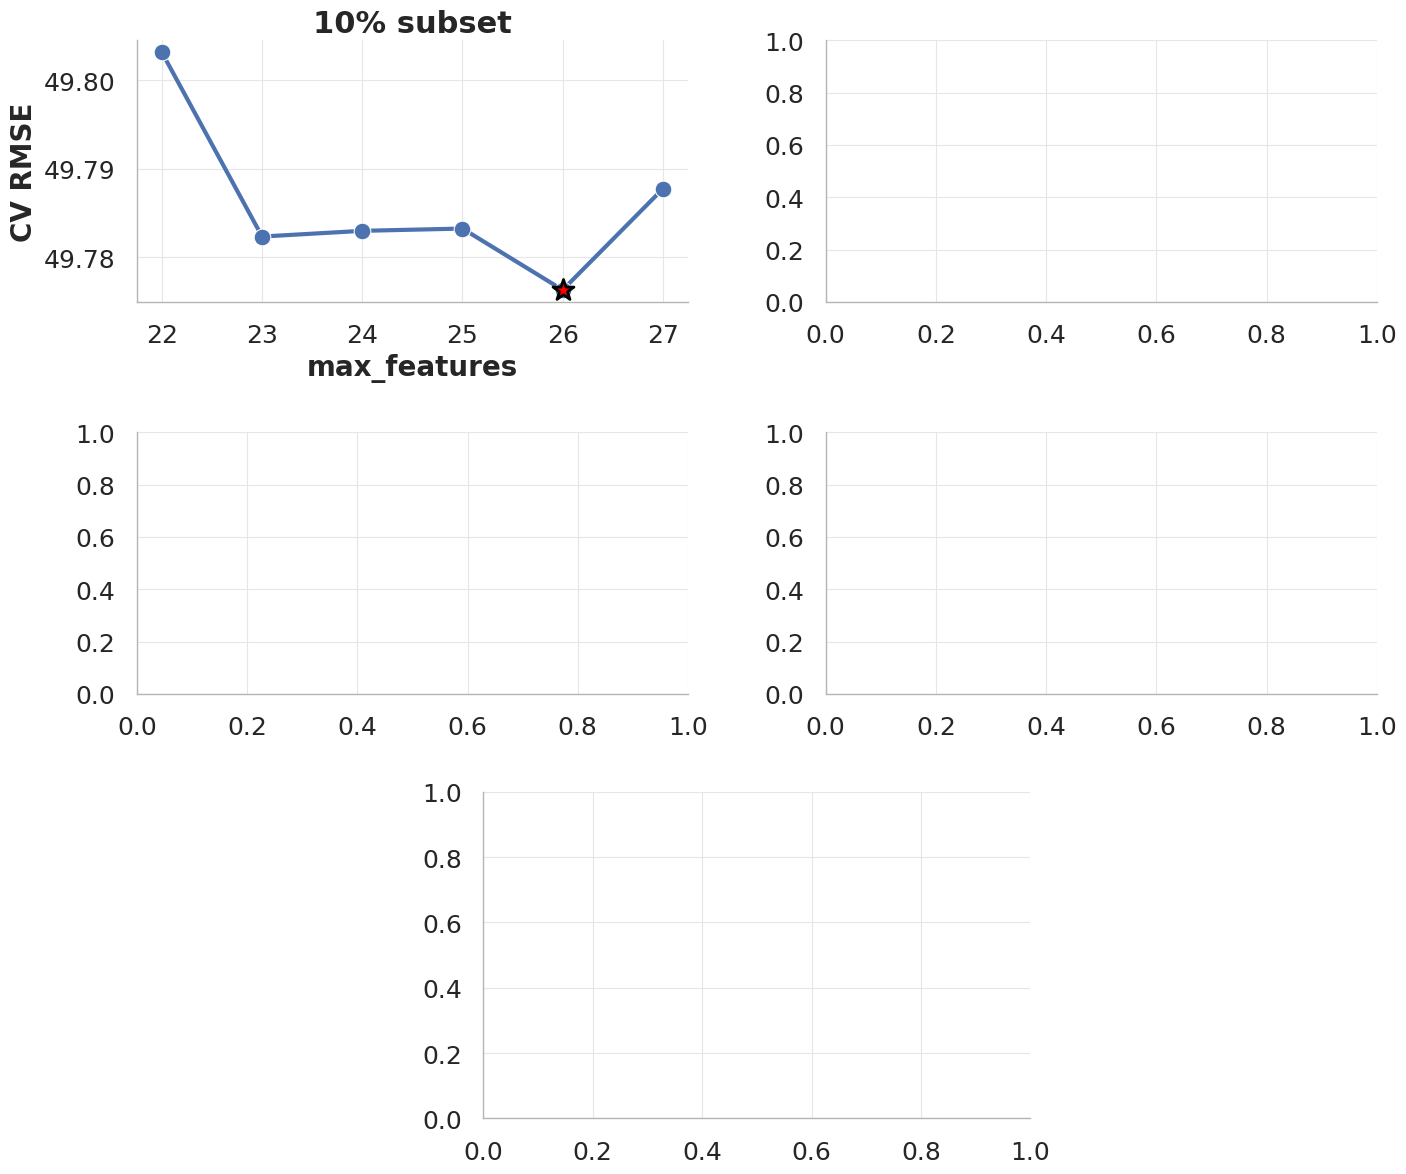

In [ ]:
# =========================
# Multi-panel Combined Plot (with centered last plot)
# =========================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter
import math

# Paths
BASE_DIR  = "/content/drive/MyDrive/MSc Research/Random Forest/RF"
ARTIFACTS_DIR = os.path.join(BASE_DIR, "artifacts")

# Load summary
summary_csv  = os.path.join(ARTIFACTS_DIR, "rf_summary.csv")
summary_df = pd.read_csv(summary_csv)

# Style (bigger for publication)
sns.set_theme(style="whitegrid", context="poster")
plt.rcParams.update({
    "axes.titleweight": "bold",
    "axes.labelweight": "semibold",
    "axes.edgecolor": "#B5B5B5",
    "axes.linewidth": 1.0,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.8,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "axes.formatter.use_locale": False,
})

# --- Truncate function for y-axis (2 decimals, no rounding) ---
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return math.trunc(n * multiplier) / multiplier

def trunc_formatter(x, pos):
    return f"{truncate(x, 2):.2f}"

def plot_one_panel(ax, csv_path, title):
    dfc = pd.read_csv(csv_path)
    if "param_max_features" not in dfc or "rmse" not in dfc:
        ax.set_visible(False)
        return

    agg = (dfc.groupby("param_max_features", as_index=False)["rmse"]
                .mean()
                .sort_values("param_max_features"))

    sns.lineplot(data=agg, x="param_max_features", y="rmse", marker="o", lw=3.0, ax=ax)
    ax.set_title(title, fontsize=22, weight="bold")
    ax.set_xlabel("max_features", fontsize=20, weight="semibold")
    ax.set_ylabel("CV RMSE", fontsize=20, weight="semibold")

    # highlight best (star only, no text box)
    i_min = agg["rmse"].idxmin()
    xm, ym = int(agg.loc[i_min, "param_max_features"]), float(agg.loc[i_min, "rmse"])
    ax.scatter([xm], [ym], s=250, c="red", marker="*", edgecolors="black", zorder=5)

    # ✅ y-axis: truncate to 2 decimals (no rounding)
    ax.yaxis.set_major_formatter(FuncFormatter(trunc_formatter))


# --- GridSpec Layout ---
fig = plt.figure(figsize=(16, 14))
outer = fig.add_gridspec(2, 1, height_ratios=[2, 1])

# Top 2×2 grid for first four subsets
top = outer[0].subgridspec(2, 2, wspace=0.25, hspace=0.5)
ax_10  = fig.add_subplot(top[0, 0])
ax_25  = fig.add_subplot(top[0, 1])
ax_50  = fig.add_subplot(top[1, 0])
ax_75  = fig.add_subplot(top[1, 1])

# Bottom 1×3 grid, use only middle cell for centered plot
bottom = outer[1].subgridspec(1, 3, width_ratios=[1, 2, 1])
ax_100 = fig.add_subplot(bottom[0, 1])

# --- Plot each subset ---
plot_one_panel(ax_10,  summary_df.loc[0, "cv_refined_csv"], "10% subset")
plot_one_panel(ax_25,  summary_df.loc[1, "cv_refined_csv"], "25% subset")
plot_one_panel(ax_50,  summary_df.loc[2, "cv_refined_csv"], "50% subset")
plot_one_panel(ax_75,  summary_df.loc[3, "cv_refined_csv"], "75% subset")
plot_one_panel(ax_100, summary_df.loc[4, "cv_refined_csv"], "100% subset")

plt.tight_layout(rect=[0, 0, 1, 0.96])

# --- Save as PDF ---
out_pdf = os.path.join(ARTIFACTS_DIR, "rf_cv_curve_panels.pdf")
plt.savefig(out_pdf, format="pdf", dpi=600, bbox_inches="tight")

plt.show()


In [ ]:
import os, json, pandas as pd

# Paths
ARTIFACTS_DIR = "/content/drive/MyDrive/MSc Research/Random Forest/RF/artifacts"
summary_csv   = os.path.join(ARTIFACTS_DIR, "rf_summary.csv")
summary_json  = os.path.join(ARTIFACTS_DIR, "rf_summary.json")

if os.path.exists(summary_csv):
    # Preferred: load CSV
    summary_df = pd.read_csv(summary_csv)
    print("Loaded results from CSV:")
    display(summary_df)

elif os.path.exists(summary_json):
    # Fallback: load JSON if CSV missing
    with open(summary_json, "r", encoding="utf-8") as f:
        data = json.load(f)
    summary_df = pd.DataFrame(data)
    print("Loaded results from JSON:")
    display(summary_df)

else:
    print("❌ No results file found. Please re-run the saving block to regenerate rf_summary.csv/json.")


Loaded results from CSV:


,subset,n_train,p_features,final_params,cv_rmse_refined_best,Test_R2,Test_MAE,Test_RMSE,Test_MAPE,model_path,cv_refined_csv
0,10%,15119,46,"{'bootstrap': True, 'criterion': 'squared_erro...",48.697676,0.747294,32.862094,47.083636,0.190987,/content/drive/MyDrive/MSc Research/Random For...,/content/drive/MyDrive/MSc Research/Random For...
1,25%,37797,46,"{'bootstrap': True, 'criterion': 'squared_erro...",47.381033,0.730592,33.373793,48.228755,0.188917,/content/drive/MyDrive/MSc Research/Random For...,/content/drive/MyDrive/MSc Research/Random For...
2,50%,75595,46,"{'bootstrap': True, 'criterion': 'squared_erro...",46.721580,0.752276,31.893916,46.233589,0.179180,/content/drive/MyDrive/MSc Research/Random For...,/content/drive/MyDrive/MSc Research/Random For...
3,75%,113392,46,"{'bootstrap': True, 'criterion': 'squared_erro...",46.195818,0.754525,31.902377,46.196332,0.180004,/content/drive/MyDrive/MSc Research/Random For...,/content/drive/MyDrive/MSc Research/Random For...
4,100%,151190,46,"{'bootstrap': True, 'criterion': 'squared_erro...",45.865708,0.753654,31.636300,45.993754,0.178460,/content/drive/MyDrive/MSc Research/Random For...,/content/drive/MyDrive/MSc Research/Random For...
